# Aplicação de técnicas de NLP e Aprendizado de máquina para realizar o reconhecimento de entidades por modelagem de tópicos

In [1]:
import pandas as pd
import numpy as np
import regex as re
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from minisom import MiniSom 


## 1. Importando dados da preparação e stopwords

In [2]:
PARQUET_INFORMACOES_PREPARADAS = '../../Data/Processed/informacoes_preparadas.parquet'

df= pd.read_parquet(PARQUET_INFORMACOES_PREPARADAS)

In [3]:
df.head()

,objeto,texto,data_inclusao,topico
0,Despacho nº 1665 que libera a unidade gerador...,Despacho nº 1665 que libera a unidade gerador...,2007-05-29 00:00:00,[BDP] - LEGADO
1,Despacho No. 1.694 da SFG que libera a UG1 (40...,Despacho No. 1.694 da SFG que libera a UG1 (40...,2007-05-31 00:00:00,[BDP] - LEGADO
2,Despacho nº 1731 que libera a unidade gerador...,Despacho nº 1731 que libera a unidade gerador...,2007-06-01 00:00:00,[BDP] - LEGADO
3,Portaria MME No. 100/2007 publicada no DOU de...,Portaria MME No. 100/2007 publicada no DOU de...,2007-06-01 00:00:00,[BDP] - LEGADO
4,Despacho nº 1617 que libera a unidade gerador...,Despacho nº 1617 que libera a unidade gerador...,2007-06-01 00:00:00,[BDP] - LEGADO


In [4]:
# Tópicos existentes

df['topico'].unique()

array(['[BDP] - LEGADO', 'Alteração das características técnicas',
       'Outorga', 'Autorização e concessões de equipamentos', 'Acesso',
       'Receita Anual Permitida - RAP', 'Ampliação  reforço ou melhoria',
       'Recurso Interposto', 'Tarifas', 'Entrada em operação',
       'Autorização de compartilhamento de subestação',
       'Custo Variável Unitário - CVU', 'Contratos', 'CCEE',
       'Cronograma de implantação', 'Exploração de empreendimento',
       'Garantia Física',
       'Encargo de Uso do Sistema de Transmissão - EUST',
       'Leilão de Energia', 'Reservatórios', 'Projeto prioritário',
       'Alteração de cadastro',
       'REIDI - Regime Especial de Incentivos para Desenvolvimento d',
       'Instalação de interesse restrito', 'Indisponibilidade',
       'Agenda Regulatória', 'Conformidade das características técnicas',
       'Projeto Básico', 'Audiência e Consulta Pública',
       'Bandeiras Tarifárias', 'Transferência de empreendimento',
       'Procedimentos e

In [5]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
documents = df.texto.values 

no_features = 5000

tfidf_vector = TfidfVectorizer(max_df=0.95, min_df=10,
                               max_features=no_features,
                               stop_words=stopwords,
                               token_pattern=r'[a-z]+')

tfidf = tfidf_vector.fit_transform(documents)

tfidf_feature_names = tfidf_vector.get_feature_names()

C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amos', 'at', 'est', 'estiv', 'f', 'h', 'houv', 'j', 'm', 'n', 'nhamos', 'ramos', 's', 'ser', 'ssemos', 't', 'tamb', 'ter', 'tiv', 'vamos', 'voc'] not in stop_words.
  warnings.warn(
C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
D = tfidf.todense().tolist()

In [19]:
pd.DataFrame(D, columns=tfidf_feature_names).head()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
D = scaler.fit_transform(D)

In [9]:
n_neurons = 5
m_neurons = 5

som = MiniSom(n_neurons, m_neurons, no_features)
som.pca_weights_init(D)

som.train(D, 40000, random_order=True, verbose=True)

C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\minisom.py:379: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 40000 / 40000 ] 100% - 0:00:00 left 
 quantization error: 67.19919599561238


In [10]:
top_keywords = 10

codebook = som.get_weights()

count = 1
for idx in range(n_neurons):
    for jdx in range(m_neurons):
        keywords_list_idx = np.argsort(codebook[idx, jdx, :])[-top_keywords:]
        keywords = ' '.join([tfidf_feature_names[n] for n in keywords_list_idx])
        print(f"Topic {count}: {keywords}")
        count += 1

Topic 1: atenuantes prestada oferecida determinantes ocorrendo tipificadas reabilita equipar infracionais assegurados
Topic 2: exporta rege ingressar aderentes oriental afetar transa honrar cambial aduaneiras
Topic 3: aplicacoes area cfm amp id audiencia attanofasaud dsplistadetalhe attanoaud attidefasaud
Topic 4: faturas pago cotas irm cotistas homologadas avisos respeitadas contemplam rag
Topic 5: entidades convidados encontrem reunir representam convidar passagens especialistas correr consultivo
Topic 6: acumulados parcelamento registradas convencional excedentes processamento compensa mecanismo sobras ficits
Topic 7: estrutura substitutos promovidas confian superiores autoridades assessoramento cargos dire intelig
Topic 8: iniciativa aliena assegurado doravante eletrobras divulgado disso comprador fato relevante
Topic 9: mecanismos ana vaz transposi afluentes reservada subtra destinadas peixes embarca
Topic 10: blicas atribu administrativa menu aberta protocolo canais setorial medi

In [13]:
map_categories = {v: k for k, v in enumerate(df.topico.unique())}
labels = df.topico.unique()

target = [map_categories[l] for l in df.topico.values]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

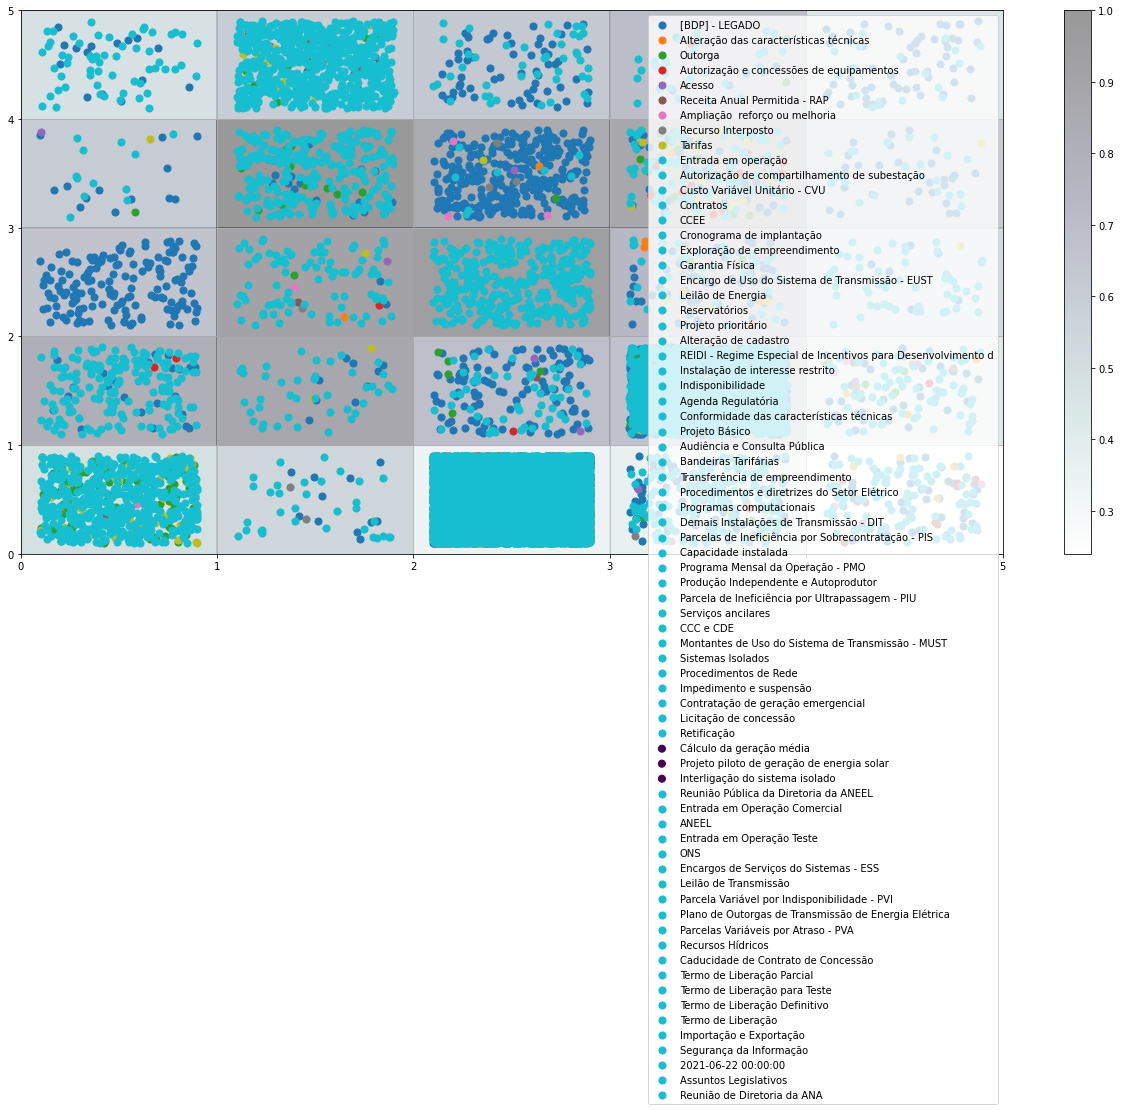

In [16]:
winners = [som.winner(doc) for doc in D]

plt.figure(figsize=(22, 10))
plt.pcolor(som.distance_map().T, cmap="bone_r", alpha=.4)
plt.colorbar()

w_x, w_y = zip(*winners)
w_x = np.array(w_x)
w_y = np.array(w_y)


colors = [plt.cm.tab10(0),plt.cm.tab10(1),plt.cm.tab10(2),
          plt.cm.tab10(3),plt.cm.tab10(4)]

for t in np.unique(target):
    idx_target = target == t
    plt.scatter(w_x[idx_target] + 0.5 + ( np.random.rand(len(w_x[idx_target])) -.5) * .8,
                w_y[idx_target] + 0.5 + ( np.random.rand(len( w_y[idx_target] )) -.5) * .8,
                s=50,
                c=plt.cm.tab10(t),
                label=labels[t])
plt.legend(loc='upper right')
plt.grid()

## 2. Vetorizando com tf-idf

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

### 2.1 Verificando o vocabulário da tokenização

In [22]:
vocab = np.array(tfidf_feature_names)

### Como o interesse é o de identificar entidades, técnicas como a de lemetização não são interessantes, pois poderiam diminuir a quantidade de informações de interesse. Podemos identificar também que muitas palavras poderiam ainda ser eliminadas como stopwords e este processo poderia se repetir por muitas vezes. A título de exercício vamos continuar o processamento com todas as palavras vetorizadas.

## 3. Modelagem de tópicos com NMF

Fatoração de matriz não negativa (NMF) é uma técnica não supervisionada, logo, não há rotulagem de tópicos nos quais o modelo será treinado. O NMF decompõe vetores de dimensões elevadas em uma representação de dimensões inferiores. Esses vetores de dimensão inferior são não negativos, o que também significa que seus coeficientes não são negativos.

Usando a matriz original (X), o NMF fornecerá duas matrizes (W e H), onde:
 * W são os tópicos encontrados 
 * H são os coeficientes (pesos) para esses tópicos. 

Em outras palavras: X são documentos por palavras (original), H são documentos por tópicos e W são tópicos por palavras.

Para o nosso caso, assumindo 3491 documentos, 2892 palavras e 30 tópicos, obteríamos as seguintes 3 matrizes:

X = tfidf_vectorizer.transform(textos dos documentos)<br>
W = nmf.components_<br>
H = nmf.transform(X)<br>
X = 3491 x 2892<br>
W = 3491 x 30<br>
H = 30 x 2892<br>

O NMF modificará os valores iniciais de W e H para que o produto se aproxime de A até que o erro de aproximação convirja ou as iterações máximas sejam alcançadas.

Em nosso caso, os vetores de alta dimensão serão pesos tf-idf, mas podem ser qualquer coisa, incluindo vetores de palavras ou uma simples contagem bruta de palavras.

### 3.1 Uso de NMF para 10 tópicos, 10 palavras por tópico

In [23]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [24]:
# Quantidade de palavras nos tópicos
num_top_words=10

model_nmf = NMF(n_components=10, max_iter=350, init='nndsvd')

W = model_nmf.fit_transform(tfidf)

H = model_nmf.components_

print(show_topics(H))

['at portaria projeto art in es cio s autorizada implanta', 'opera in cio teste sfg libera dia unidade estar ug', 'resolu art anexo transmiss es artigo instala concess el trica', 'mme interessada portaria art desenvolvimento objeto reidi rio encontra planejamento', 'art ufv at resolu geradora central in cio sob normativa', 'ventos eol santa kv s alterar lica cv renov energias', 'p blica contribui gov br participa www subs aneel envio', 'cvu ute trica el conhecer provimento despacho termel decide m', 'ug kw gera liberar totalizando capacidade conferidas unidades geradoras aneel', 'sica garantia f portaria energia art montante efeitos pch mme']


### 3.2 Visulização de tópicos com NMF e LDA [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) por Olivier Grisel <olivier.grisel@ensta.org>, Lars Buitinck e Chyi-Kwei Yau <chyikwei.yau@gmail.com>

3491 Documentos, 2892 palavras, 10 tópicos e 20 top palavras

Extracting tf-idf features for NMF...
done in 11.543s.
Extracting tf features for LDA...
done in 9.210s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3491 and n_features=2892...


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


done in 17.400s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


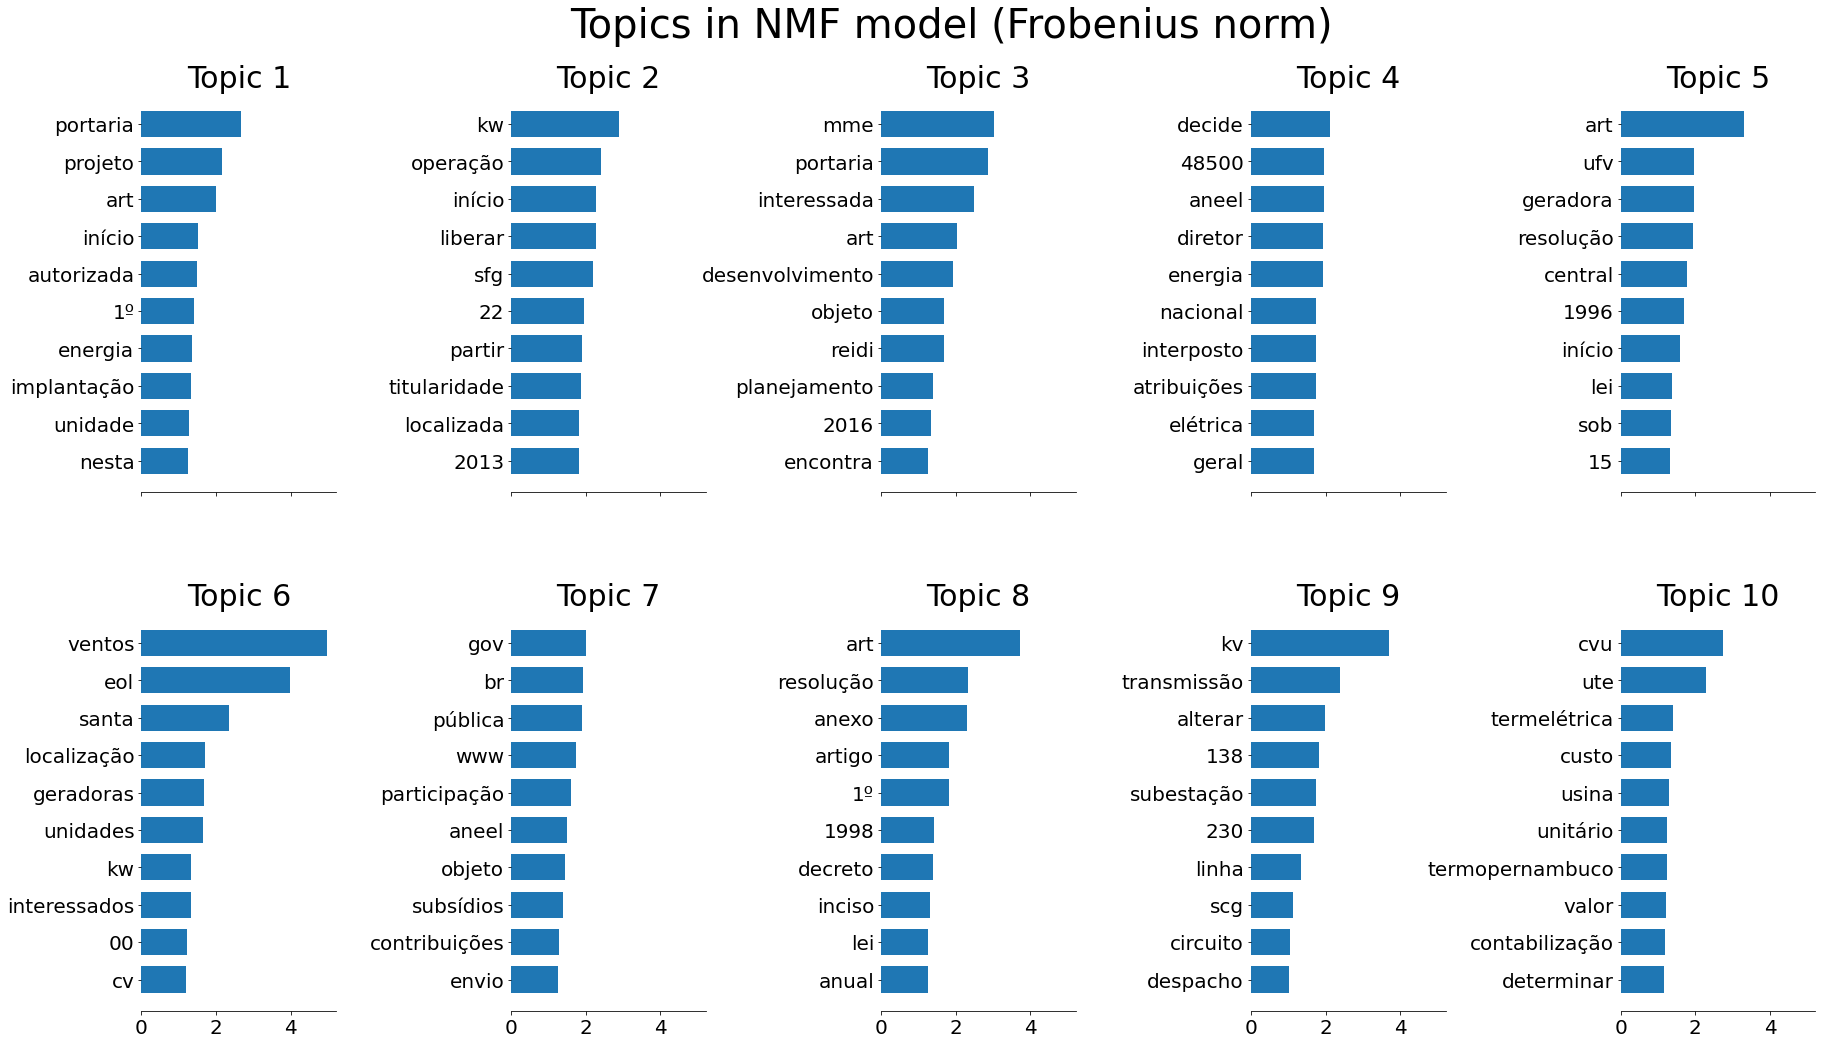



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=3491 and n_features=2892...


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


done in 234.722s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


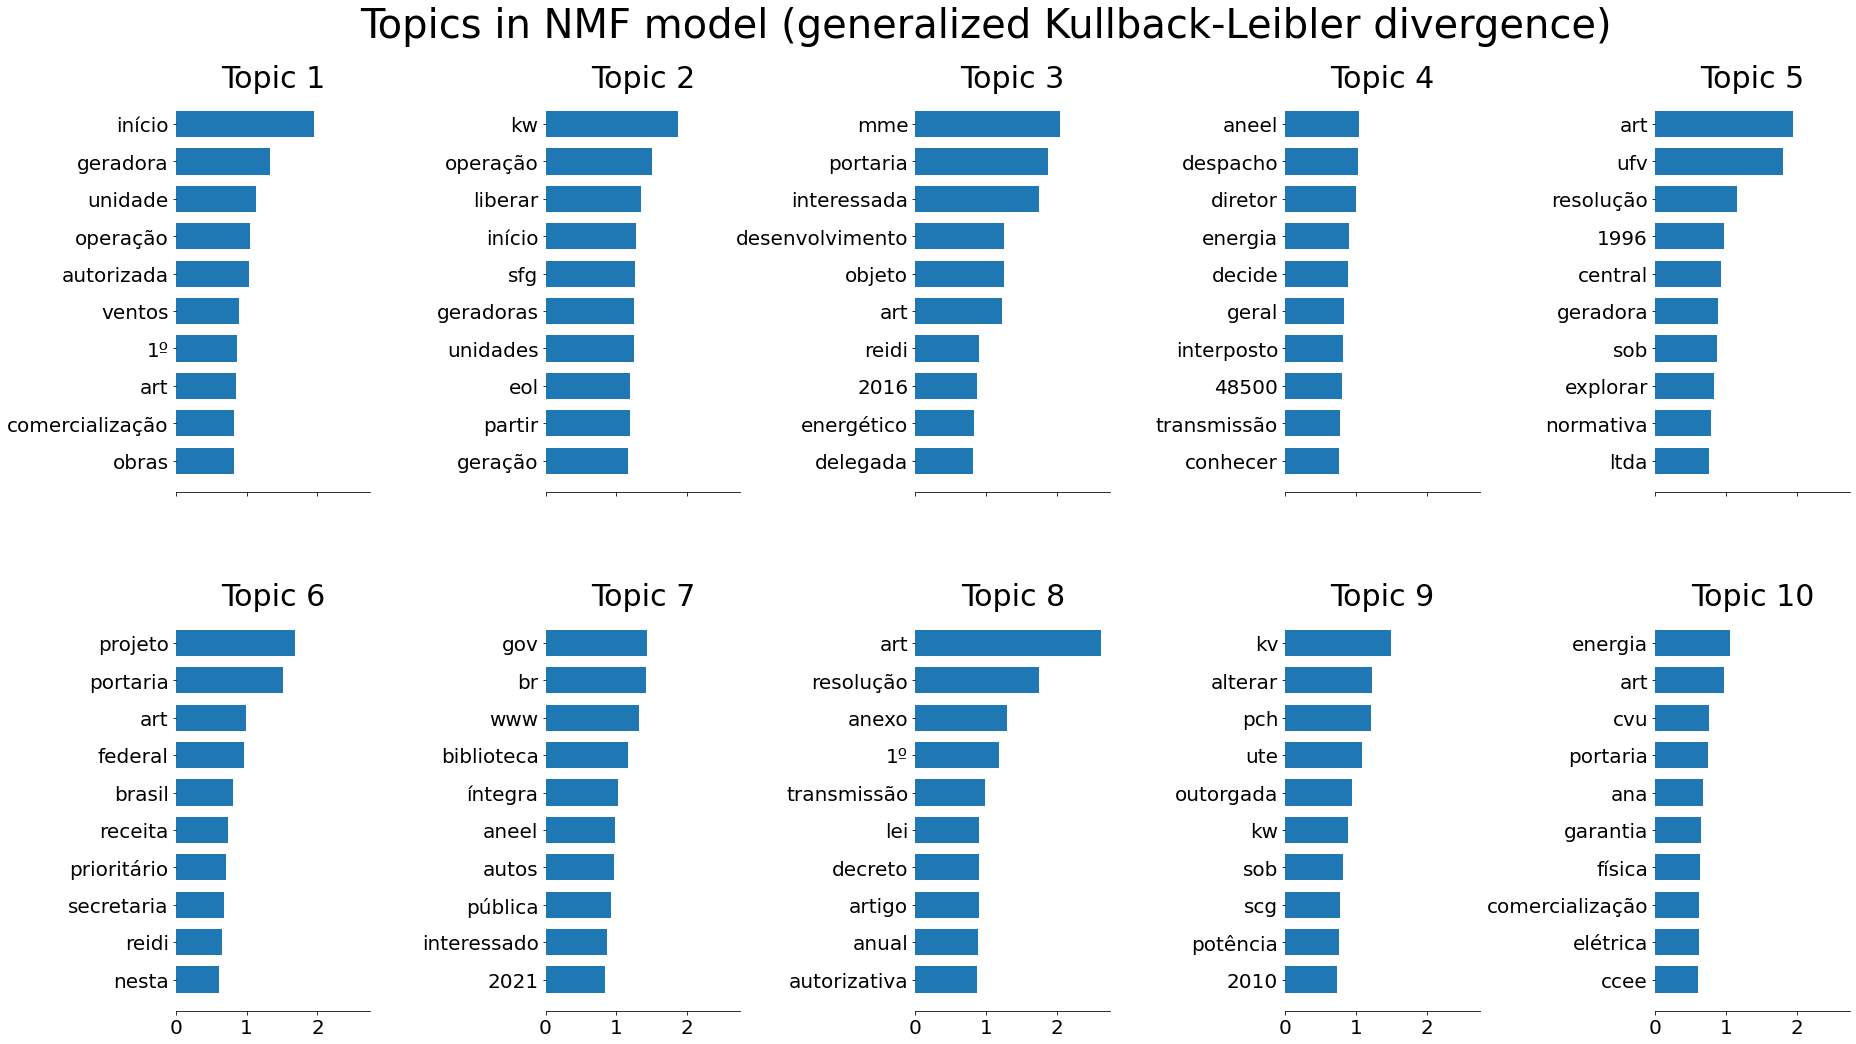



 Fitting LDA models with tf features, n_samples=3491 and n_features=2892...
done in 95.842s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


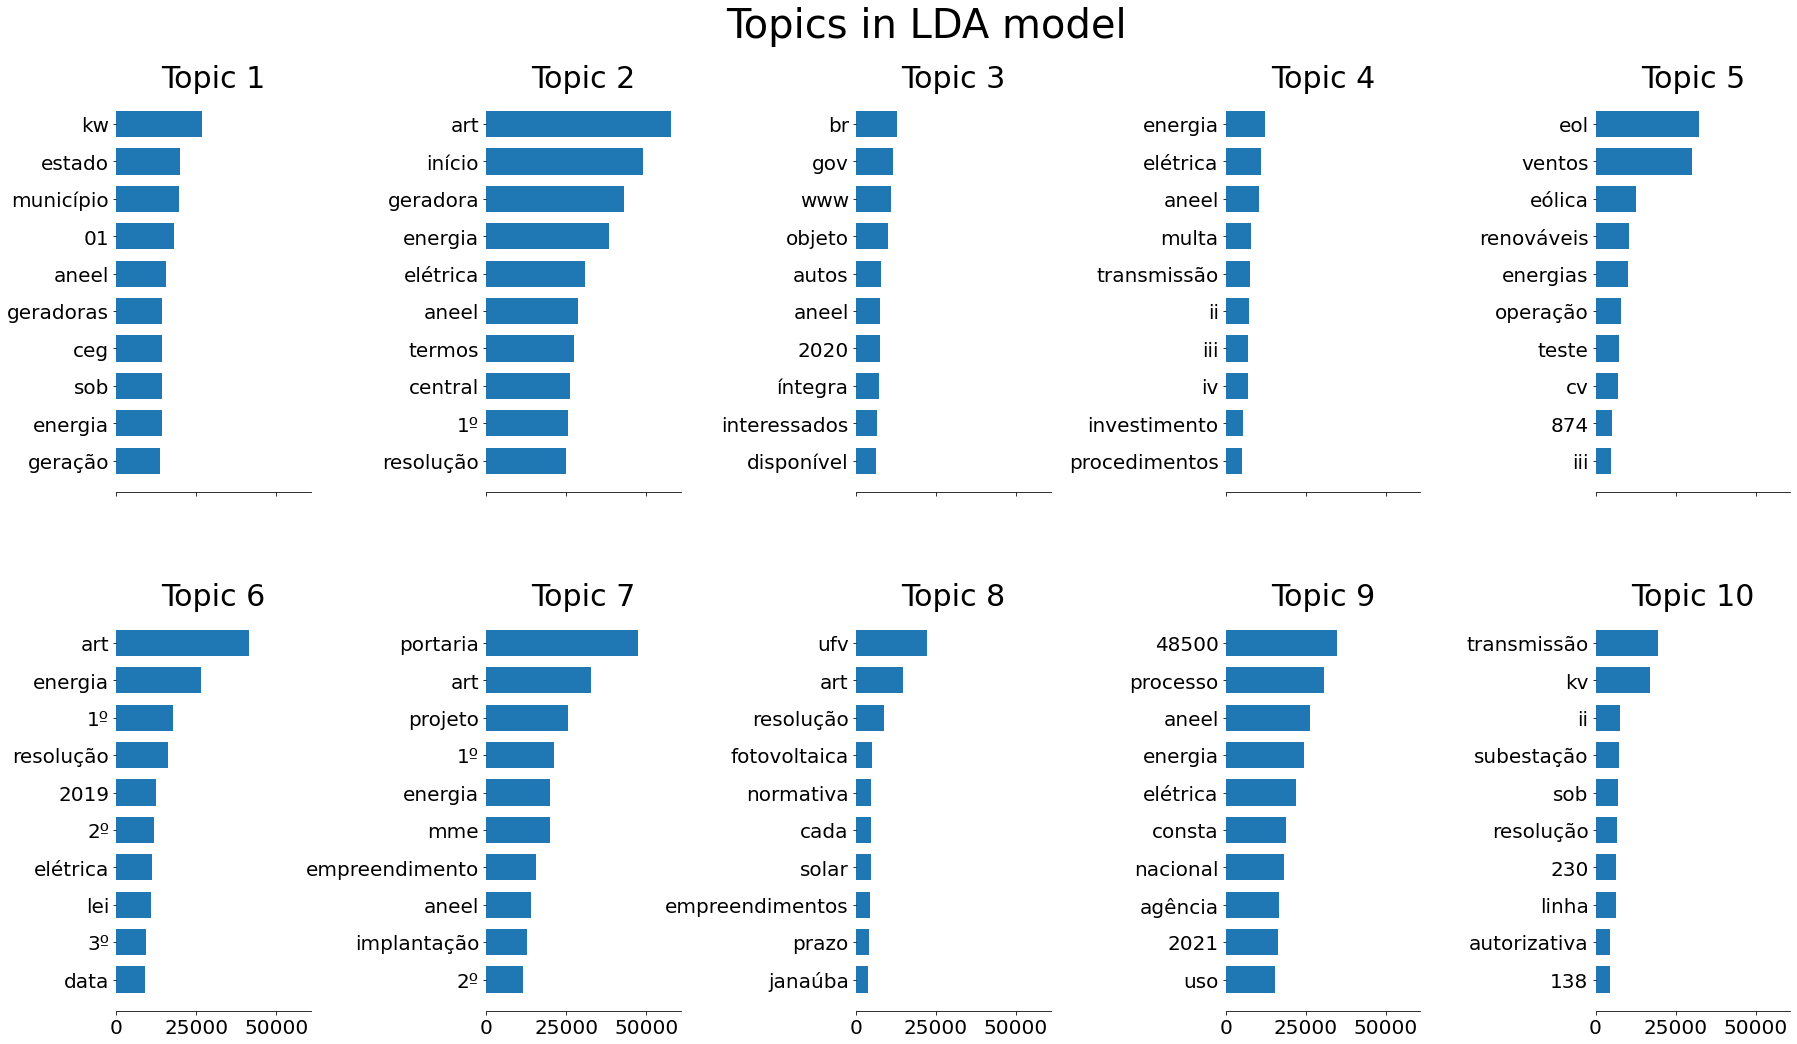

In [26]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 3491
n_features = 2892
n_components = 10
n_top_words = 10

# Adaptação do data_sample
data_samples = (df['texto'])

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=3,
                                     max_features=n_features,
                                     stop_words=stopwords)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=3,
                                # max_features=n_features,
                                stop_words=stopwords)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5, init = 'nndsvda').fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

## 4. Clusterização por KNN 

In [28]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=10, verbose=True)

km.fit_transform(D)

print(show_topics(km.cluster_centers_))

Initialization complete
Iteration 0, inertia 261102161.76527584
Iteration 1, inertia 193110983.4249088
Iteration 2, inertia 192315353.95162722
Iteration 3, inertia 191896361.48063576
Iteration 4, inertia 191779572.82836202
Iteration 5, inertia 191624699.9919414
Iteration 6, inertia 191567296.76138896
Iteration 7, inertia 191528236.3309846
Iteration 8, inertia 191465593.19541448
Iteration 9, inertia 191415355.08291242
Iteration 10, inertia 191360678.72231776
Iteration 11, inertia 191293303.61320445
Iteration 12, inertia 191284874.34876826
Iteration 13, inertia 191284292.1459716
Iteration 14, inertia 191283331.87006208
Iteration 15, inertia 191282738.0508015
Iteration 16, inertia 191282567.8731302
Iteration 17, inertia 191282375.80236542
Iteration 18, inertia 191282333.15031457
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 269509849.57911897
Iteration 1, inertia 194796922.1195532
Iteration 2, inertia 194260341.41519153
Iteration 3, inertia 19

### 4.1 Organização dos clusters

In [29]:
from collections import Counter
c = Counter(km.labels_)
c

Counter({6: 12683,
         5: 15715,
         3: 494,
         1: 87,
         0: 2087,
         4: 3576,
         9: 2487,
         8: 1813,
         7: 352,
         2: 678})